In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np
import sklearn
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import log_evaluation
from sklearn.metrics import r2_score

In [75]:
data = pd.read_csv("stock_price.csv")
print(data.head())
print(data.info())
print(data.isnull().sum())
print(data.describe())

          日付け     終値     始値     高値     安値      出来高   変化率 %
0  2024-08-01  156.3  159.3  159.4  156.1   79.15M  -2.56%
1  2024-07-31  160.4  158.2  160.7  158.1  173.91M   1.07%
2  2024-07-30  158.7  158.8  159.2  158.0  138.14M  -0.63%
3  2024-07-29  159.7  158.7  160.2  158.4  126.28M   1.14%
4  2024-07-26  157.9  159.3  159.6  157.9  155.08M  -0.13%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日付け     9202 non-null   object 
 1   終値      9202 non-null   float64
 2   始値      9202 non-null   float64
 3   高値      9202 non-null   float64
 4   安値      9202 non-null   float64
 5   出来高     9202 non-null   object 
 6   変化率 %   9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB
None
日付け      0
終値       0
始値       0
高値       0
安値       0
出来高      0
変化率 %    0
dtype: int64
                終値           始値           高値           安値


In [76]:
data=data.rename(columns={'日付け':'date',"終値":"end","始値":"start","高値":"max","安値":"min","出来高":"event","変化率 %":"raito"})


In [77]:
def convert_million(x):
    if isinstance(x, str) and x.endswith("M"):
        return float(x[:-1]) * 1_000_000
    if isinstance(x, str) and x.endswith("B"):
        return float(x[:-1]) * 1_000_000_000 
    else:  
        return pd.to_numeric(x, errors="coerce")
    
def convert_percent(x):
    if isinstance(x, str) and x.endswith("%"):
        # '%' を外して小数に変換
        return float(x.replace("%", "")) / 100
    return pd.to_numeric(x, errors="coerce")



data["date"] = pd.to_datetime(data["date"])
data["event"] = data["event"].apply(convert_million)
data["raito"] = data["raito"].apply(convert_percent)
print(data.info())
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9202 non-null   datetime64[ns]
 1   end     9202 non-null   float64       
 2   start   9202 non-null   float64       
 3   max     9202 non-null   float64       
 4   min     9202 non-null   float64       
 5   event   9202 non-null   float64       
 6   raito   9202 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 503.4 KB
None


,date,end,start,max,min,event,raito
0,2024-08-01,156.3,159.3,159.4,156.1,7.915000e+07,-0.0256
1,2024-07-31,160.4,158.2,160.7,158.1,1.739100e+08,0.0107
2,2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063
3,2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114
4,2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013
...,...,...,...,...,...,...,...
9197,1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482
9198,1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393
9199,1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174
9200,1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543


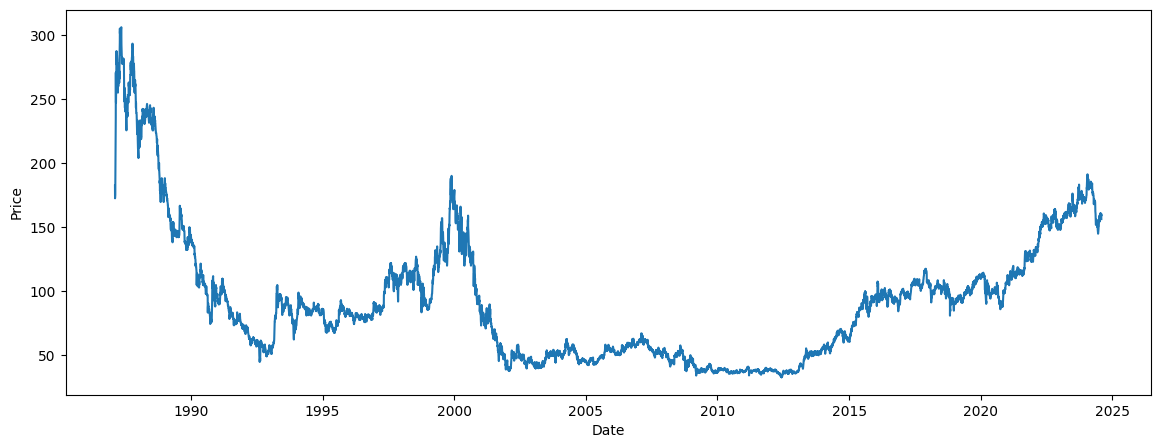

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(data["date"],data["end"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


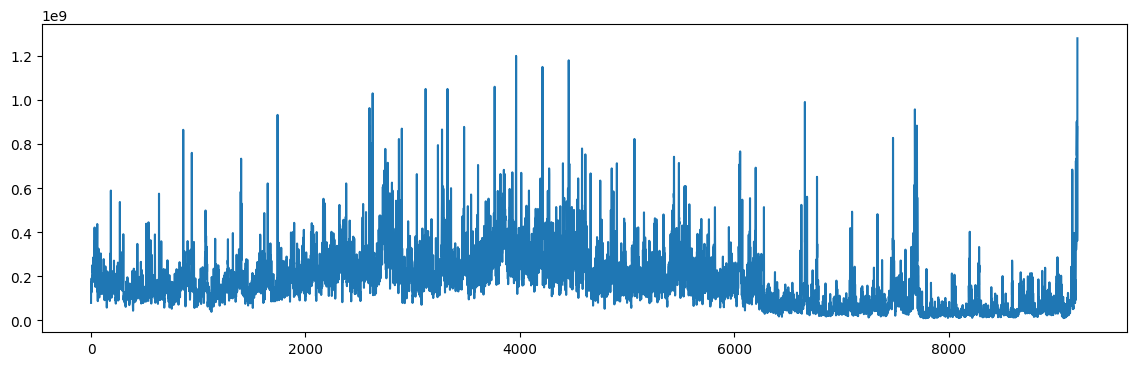

In [38]:
plt.figure(figsize=(14,4))
plt.plot(data["event"])
plt.show()


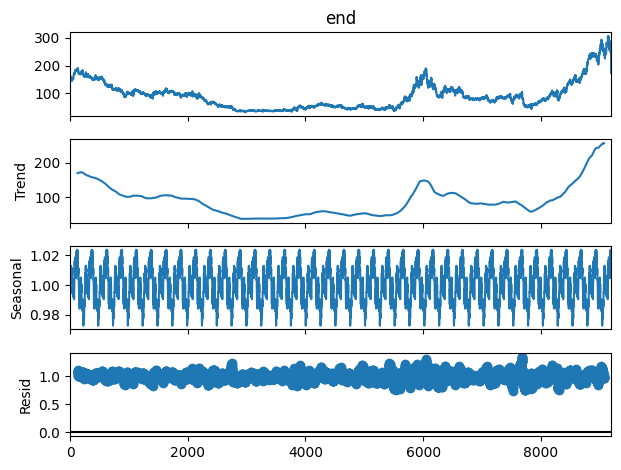

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["end"], model="multiplicative", period=252)
result.plot()
plt.show()


In [78]:
data["target"] = data["end"].shift(-1)
#移動平均
data["MA5"] = data["end"].rolling(5).mean()
data["MA25"] = data["end"].rolling(25).mean()

#相対力指数
delta = data["end"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
RS = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + RS))

# MACD
data["EMA12"] = data["end"].ewm(span=12, adjust=False).mean()
data["EMA26"] = data["end"].ewm(span=26, adjust=False).mean()
data["MACD"] = data["EMA12"] - data["EMA26"]
data["Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

# ボリンジャーバンド
data["MA20"] = data["end"].rolling(20).mean()
data["STD20"] = data["end"].rolling(20).std()
data["BB_up"] = data["MA20"] + 2 * data["STD20"]
data["BB_down"] = data["MA20"] - 2 * data["STD20"]
data["BB_width"] = data["BB_up"] - data["BB_down"]

# Volume（出来高）
data["Volume"] = data["event"]

# OBV
data["direction"] = np.where(data["end"].diff() > 0, 1, -1)
data["OBV"] = (data["event"] * data["direction"]).cumsum()


In [51]:

data = data.dropna().reset_index(drop=True)
exclude = ["date", "target","end","start", "max", "min", "event"]
features = [col for col in data.columns if col not in exclude]

X = data[features]
y = data["target"]


In [52]:
split = int(len(data) * 0.8)

X_train = X.iloc[:split]
y_train = y.iloc[:split]
X_test = X.iloc[split:]
y_test = y.iloc[split:]

model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    verbose=50
)
model.fit(X_train, y_train)

pred = model.predict(X_test)


C:\Users\zui08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's rmse: 51.4455	valid_0's l2: 2646.64
[100]	valid_0's rmse: 39.5446	valid_0's l2: 1563.77
[150]	valid_0's rmse: 35.3875	valid_0's l2: 1252.28
[200]	valid_0's rmse: 34.217	valid_0's l2: 1170.81
[250]	valid_0's rmse: 33.7276	valid_0's l2: 1137.55
[300]	valid_0's rmse: 33.5757	valid_0's l2: 1127.32
[350]	valid_0's rmse: 33.4849	valid_0's l2: 1121.24
[400]	valid_0's rmse: 33.4678	valid_0's l2: 1120.09
[450]	valid_0's rmse: 33.4541	valid_0's l2: 1119.18
[500]	valid_0's rmse: 33.4473	valid_0's l2: 1118.72
[550]	valid_0's rmse: 33.4378	valid_0's l2: 1118.09
[600]	valid_0's rmse: 33.4519	valid_0's l2: 1119.03
[650]	valid_0's rmse: 33.4598	valid_0's l2: 1119.56
[700]	valid_0's rmse: 33.4621	valid_0's l2: 1119.71
[750]	valid_0's rmse: 33.4776	valid_0's l2: 1120.75
[800]	valid_0's rmse: 33.4973	valid_0's l2: 1122.07


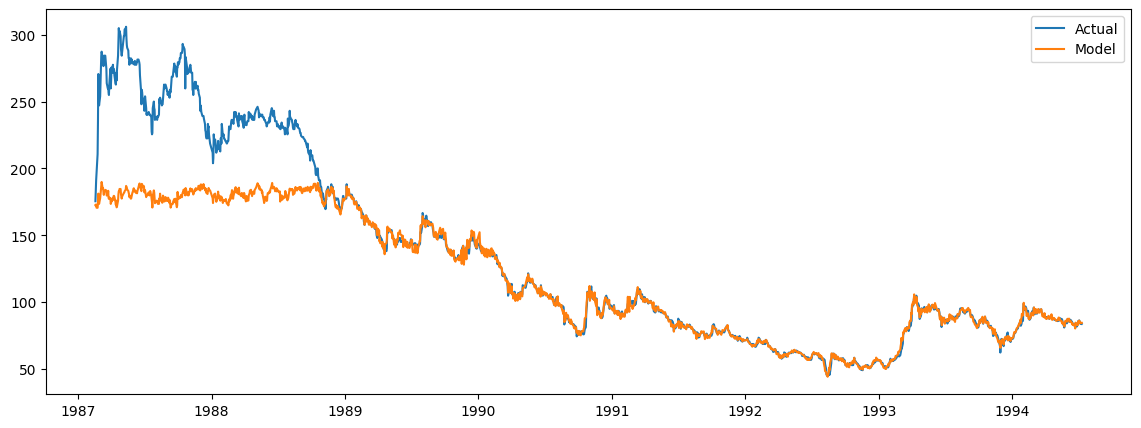

In [53]:
plt.figure(figsize=(14,5))
plt.plot(data["date"].iloc[split:], y_test, label="Actual")
plt.plot(data["date"].iloc[split:], pred, label="Model")
plt.legend()
plt.show()


In [56]:
r2_model = r2_score(y_test, pred)

naive_pred = data["end"].iloc[split:].values
r2_naive = r2_score(y_test, naive_pred)

print("Model R2:", r2_model)
print("Naive R2:", r2_naive)
print("Improvement:", r2_model - r2_naive)

Model R2: 0.7713165128511225
Naive R2: 0.9980990128543277
Improvement: -0.2267825000032052


In [79]:
data["LogReturn"] = np.log(data["end"] / data["end"].shift(1))
data["LogReturn_5"] = np.log(data["end"] / data["end"].shift(5))
data["LogReturn_10"] = np.log(data["end"] / data["end"].shift(10))



In [ ]:
data = data.dropna().reset_index(drop=True)
exclude = ["date", "target", "end"]
features = [c for c in data.columns if c not in exclude]
X = data[features]
y = data["target"]

In [72]:
split = int(len(data) * 0.8)

X_train = X.iloc[:split]
y_train = y.iloc[:split]
X_test = X.iloc[split:]
y_test = y.iloc[split:]

model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    verbose=50
)
model.fit(X_train, y_train)

pred = model.predict(X_test)

C:\Users\zui08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's rmse: 50.0882	valid_0's l2: 2508.82
[100]	valid_0's rmse: 37.6911	valid_0's l2: 1420.62
[150]	valid_0's rmse: 33.476	valid_0's l2: 1120.64
[200]	valid_0's rmse: 31.9528	valid_0's l2: 1020.98
[250]	valid_0's rmse: 31.399	valid_0's l2: 985.897
[300]	valid_0's rmse: 31.177	valid_0's l2: 972.004
[350]	valid_0's rmse: 31.0897	valid_0's l2: 966.569
[400]	valid_0's rmse: 31.0652	valid_0's l2: 965.046
[450]	valid_0's rmse: 31.0509	valid_0's l2: 964.157
[500]	valid_0's rmse: 31.0699	valid_0's l2: 965.34
[550]	valid_0's rmse: 31.0806	valid_0's l2: 966.003
[600]	valid_0's rmse: 31.081	valid_0's l2: 966.026
[650]	valid_0's rmse: 31.0817	valid_0's l2: 966.073
[700]	valid_0's rmse: 31.0796	valid_0's l2: 965.944
[750]	valid_0's rmse: 31.078	valid_0's l2: 965.844
[800]	valid_0's rmse: 31.0776	valid_0's l2: 965.816


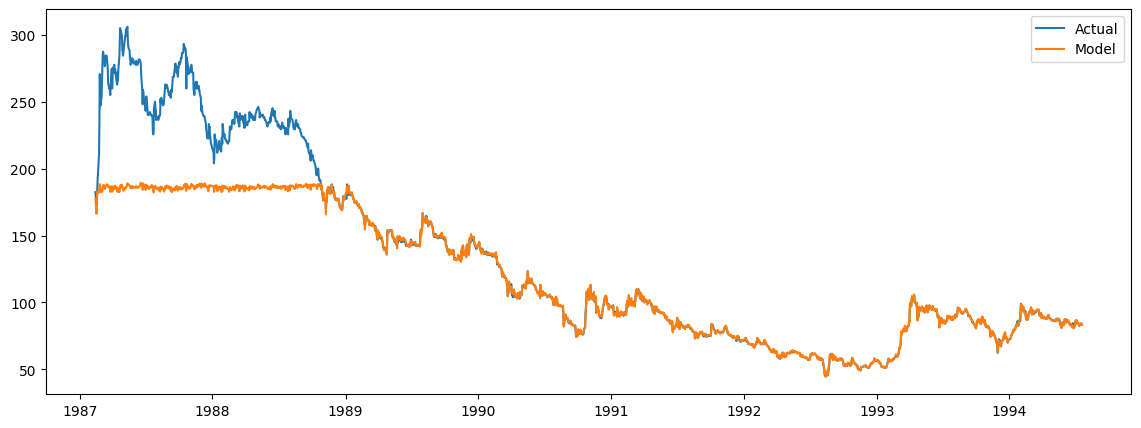

In [73]:
plt.figure(figsize=(14,5))
plt.plot(data["date"].iloc[split:], y_test, label="Actual")
plt.plot(data["date"].iloc[split:], pred, label="Model")
plt.legend()
plt.show()

In [74]:
r2_model = r2_score(y_test, pred)

naive_pred = data["end"].iloc[split:].values
r2_naive = r2_score(y_test, naive_pred)

print("Model R2:", r2_model)
print("Naive R2:", r2_naive)
print("Improvement:", r2_model - r2_naive)

Model R2: 0.80270474030398
Naive R2: 0.9980908318301888
Improvement: -0.19538609152620878


In [80]:
# Lag（過去の株価）
data["end_lag1"] = data["end"].shift(1)
data["end_lag3"] = data["end"].shift(3)
data["end_lag5"] = data["end"].shift(5)



In [81]:
data = data.dropna().reset_index(drop=True)
exclude = ["date", "target", "end"]
features = [c for c in data.columns if c not in exclude]
X = data[features]
y = data["target"]

split = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

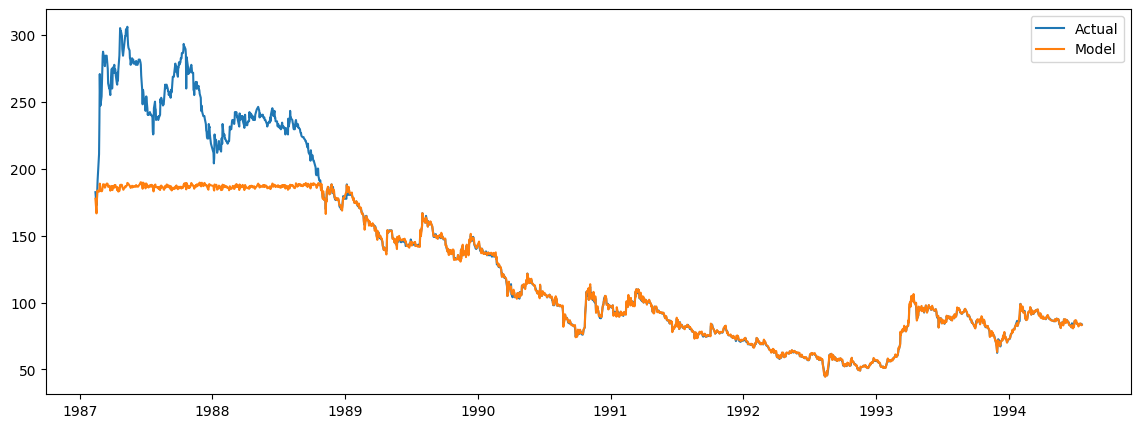

In [82]:
plt.figure(figsize=(14,5))
plt.plot(data["date"].iloc[split:], y_test, label="Actual")
plt.plot(data["date"].iloc[split:], pred, label="Model")
plt.legend()
plt.show()

In [83]:
r2_model = r2_score(y_test, pred)

naive_pred = data["end"].iloc[split:].values
r2_naive = r2_score(y_test, naive_pred)

print("Model R2:", r2_model)
print("Naive R2:", r2_naive)
print("Improvement:", r2_model - r2_naive)

Model R2: 0.8064689652547312
Naive R2: 0.998091739967176
Improvement: -0.19162277471244482
